# BERT for Text Extraction

Fine-tuning of pretrained [BERT](https://arxiv.org/pdf/1810.04805.pdf) on the [SQuAD](https://arxiv.org/abs/1606.05250) dataset.

## Introduction

This demonstration uses SQuAD (Stanford Question-Answering Dataset).
In SQuAD, an input consists of a question, and a paragraph for context.
The goal is to find the span of text in the paragraph that answers the question.

We fine-tune a BERT model to perform this task as follows:

1. Feed the context and the question as inputs to BERT.
2. Take two vectors S and T with dimensions equal to that of
   hidden states in BERT.
3. Compute the probability of each token being the start and end of
   the answer span. The probability of a token being the start of
   the answer is given by a dot product between S and the representation
   of the token in the last layer of BERT, followed by a softmax over all tokens.
   The probability of a token being the end of the answer is computed
   similarly with the vector T.
4. Fine-tune BERT and learn S and T along the way.

## Setup


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install tokenizers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os
import tempfile
import re
import json
import string
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt

max_len = 384
configuration = BertConfig()  # default parameters and configuration for BERT

## Set random seeds for reproducibility

In [9]:
np.random.seed(1)
tf.random.set_seed(2)

## Set-up BERT tokenizer


In [10]:
# Save the slow pretrained tokenizer
slow_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
save_path = "bert_base_uncased/"
if not os.path.exists(save_path):
    os.makedirs(save_path)
slow_tokenizer.save_pretrained(save_path)

# Load the fast tokenizer from saved file
tokenizer = BertWordPieceTokenizer("bert_base_uncased/vocab.txt", lowercase=True)

In [ ]:
# Test the tokenizer
vector = tokenizer.encode('Hello!')
print('IDs:', vector.ids)
print('Offsets:', vector.offsets)

IDs: [101, 7592, 999, 102]
Offsets: [(0, 0), (0, 5), (5, 6), (0, 0)]


## Load the data


In [ ]:
DATASET_FILEPATH = 'dataset.json'

with open(DATASET_FILEPATH, 'r') as f:
    dataset = json.load(f)['data']

In [ ]:
train_size = 0.9

# Calculate the index at which to split the list for the train and validation sets
train_index = int(train_size * len(dataset))

train_set = dataset[:train_index]
validation_set = dataset[train_index:]

print(len(train_set), len(validation_set))

397 45


## Preprocess the data

In [ ]:
class SquadExample:
    def __init__(self, question, context, start_char_idx, answer_text, all_answers):
        self.question = question
        self.context = context
        self.start_char_idx = start_char_idx
        self.answer_text = answer_text
        self.all_answers = all_answers
        self.skip = False

    def preprocess(self):
        context = self.context
        question = self.question
        answer_text = self.answer_text
        start_char_idx = self.start_char_idx

        # Clean context, answer and question by removing excessive whitespaces
        context = " ".join(str(context).split())
        question = " ".join(str(question).split())
        answer = " ".join(str(answer_text).split())

        # Find end character index of answer in context
        end_char_idx = start_char_idx + len(answer)
        if end_char_idx >= len(context):
            self.skip = True
            return

        # Mark the character indexes in context that are in the answer
        is_char_in_ans = [0] * len(context)
        for idx in range(start_char_idx, end_char_idx):
          is_char_in_ans[idx] = 1

        # Tokenize context
        tokenized_context = tokenizer.encode(context)

        # Find tokens that were created from answer characters
        ans_token_idx = []
        for idx, (start, end) in enumerate(tokenized_context.offsets):
            if sum(is_char_in_ans[start:end]) > 0:
                ans_token_idx.append(idx)

        if len(ans_token_idx) == 0:
            self.skip = True
            return

        # Find start and end token index for tokens from answer
        start_token_idx = ans_token_idx[0]
        end_token_idx = ans_token_idx[-1]

        # Tokenize question
        tokenized_question = tokenizer.encode(question)

        # Create inputs
        input_ids = tokenized_context.ids + tokenized_question.ids[1:]
        token_type_ids = [0] * len(tokenized_context.ids) + [1] * len(
            tokenized_question.ids[1:]
        )
        attention_mask = [1] * len(input_ids)

        # Pad and create attention masks.
        # Skip if truncation is needed
        padding_length = max_len - len(input_ids)
        if padding_length > 0:  # pad
            input_ids = input_ids + ([0] * padding_length)
            attention_mask = attention_mask + ([0] * padding_length)
            token_type_ids = token_type_ids + ([0] * padding_length)
        elif padding_length < 0:  # skip
            self.skip = True
            return

        self.input_ids = input_ids
        self.token_type_ids = token_type_ids
        self.attention_mask = attention_mask
        self.start_token_idx = start_token_idx
        self.end_token_idx = end_token_idx
        self.context_token_to_char = tokenized_context.offsets


def create_squad_examples(dataset):
    squad_examples = []
    for item in dataset:
      for para in item["paragraphs"]:
        context = para["context"]
        for qa in para["qas"]:
          question = qa["question"]
          answer_text = qa["answers"][0]["text"]
          all_answers = [_["text"] for _ in qa["answers"]]
          start_char_idx = qa["answers"][0]["answer_start"]
          squad_eg = SquadExample(
            question, context, start_char_idx, answer_text, all_answers
          )
          squad_eg.preprocess()
          squad_examples.append(squad_eg)
    
    return squad_examples


# Dimension of `x`: 3 x NUMBER_OF_EXAMPLES x MAX_LEN
# Dimension of `y`: 2 x NUMBER_OF_EXAMPLES
def create_inputs_and_targets(squad_examples):
    dataset_dict = {
        "input_ids": [],
        "token_type_ids": [],
        "attention_mask": [],
        "start_token_idx": [],
        "end_token_idx": [],
    }
    for item in squad_examples:
        if item.skip == False:
            for key in dataset_dict:
                dataset_dict[key].append(getattr(item, key))
    for key in dataset_dict:
        dataset_dict[key] = np.array(dataset_dict[key])

    x = [
        dataset_dict["input_ids"],
        dataset_dict["token_type_ids"],
        dataset_dict["attention_mask"],
    ]
    y = [
        dataset_dict["start_token_idx"],
        dataset_dict["end_token_idx"]
    ]
    return x, y


train_squad_examples = create_squad_examples(train_set)
x_train, y_train = create_inputs_and_targets(train_squad_examples)

validation_squad_examples = create_squad_examples(validation_set)
x_validation, y_validation = create_inputs_and_targets(validation_squad_examples)

In [ ]:
# Squad Example data
for prop, value in vars(train_squad_examples[0]).items():
    print(prop, ":", value)

question : To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?
context : Architecturally, the school has a Catholic character. Atop the Main Building's gold dome is a golden statue of the Virgin Mary. Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes". Next to the Main Building is the Basilica of the Sacred Heart. Immediately behind the basilica is the Grotto, a Marian place of prayer and reflection. It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858. At the end of the main drive (and in a direct line that connects through 3 statues and the Gold Dome), is a simple, modern stone statue of Mary.
start_char_idx : 515
answer_text : Saint Bernadette Soubirous
all_answers : ['Saint Bernadette Soubirous']
skip : False
input_ids : [101, 6549, 2135, 1010, 1996, 2082, 2038, 1037, 3234, 2839, 1012, 10234, 1996, 

In [ ]:
print(f"{len(train_squad_examples)} training points created.")
print(f"{len(validation_squad_examples)} validation points created.")

78629 training points created.
8970 validation points created.


## Create the Question-Answering Model using BERT and Functional API

In [ ]:
def create_model():
    ## BERT encoder
    encoder = TFBertModel.from_pretrained("bert-base-uncased")

    ## QA Model
    input_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    token_type_ids = layers.Input(shape=(max_len,), dtype=tf.int32)
    attention_mask = layers.Input(shape=(max_len,), dtype=tf.int32)
    embedding = encoder(
        input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask
    )[0]

    start_logits = layers.Dense(1, name="start_logit", use_bias=False)(embedding)
    start_logits = layers.Flatten()(start_logits)

    end_logits = layers.Dense(1, name="end_logit", use_bias=False)(embedding)
    end_logits = layers.Flatten()(end_logits)

    start_probs = layers.Activation(keras.activations.softmax)(start_logits)
    end_probs = layers.Activation(keras.activations.softmax)(end_logits)

    model = keras.Model(
        inputs=[input_ids, token_type_ids, attention_mask],
        outputs=[start_probs, end_probs],
    )
    loss_criterion = keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    optimizer = keras.optimizers.Adam(lr=5e-6)
    model.compile(optimizer=optimizer, loss=loss_criterion)
    return model

In [ ]:
use_tpu = True
if use_tpu:
    # Create distribution strategy
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect(tpu='')
    strategy = tf.distribute.TPUStrategy(tpu)

    # Create model
    with strategy.scope():
        model = create_model()
else:
    model = create_model()

model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.
/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  supe

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_3[0][0]',            

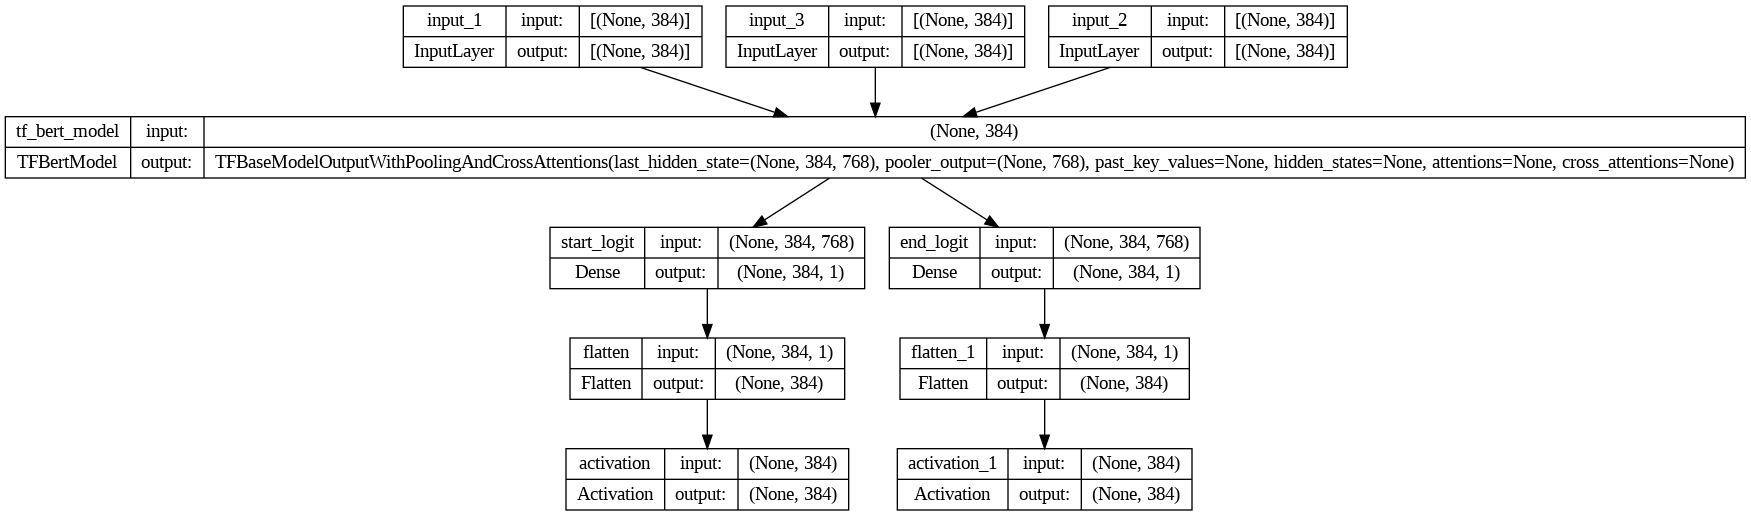

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

## Train and Evaluate

During training, some callbacks for validation will be executed.

### Create validation callbacks

These callbacks will compute the validations metrics using the validation data after every epoch.


In [ ]:
validation_examples_no_skip = [_ for _ in validation_squad_examples if _.skip == False]


def normalize_text(text):
    text = text.lower()

    # Remove punctuations
    exclude = set(string.punctuation)
    text = "".join(ch for ch in text if ch not in exclude)

    # Remove articles
    regex = re.compile(r"\b(a|an|the)\b", re.UNICODE)
    text = re.sub(regex, " ", text)

    # Remove extra white space
    text = " ".join(text.split())
    return text


def get_predicted_answers(start_predictions, end_predictions):
    """
    Each `SquadExample` object contains the character level offsets for each token
    in its input paragraph. We use them to get back the span of text corresponding
    to the tokens between our predicted start and end tokens.
    All the ground-truth answers are also present in each `SquadExample` object.
    """
    for idx, (start, end) in enumerate(zip(start_predictions, end_predictions)):
        squad_eg = validation_examples_no_skip[idx]
        offsets = squad_eg.context_token_to_char
        start_token_idx = np.argmax(start)
        end_token_idx = np.argmax(end)
        if start_token_idx >= len(offsets):  # len(offsets) is the index of the last token
            continue
        pred_char_start_idx = offsets[start_token_idx][0]
        if end_token_idx >= len(offsets):
            pred_ans = squad_eg.context[pred_char_start_idx:]
        else:
            pred_char_end_idx = offsets[end_token_idx][1]
            pred_ans = squad_eg.context[pred_char_start_idx:pred_char_end_idx]
        
        yield squad_eg, pred_ans



class ExactMatch(keras.callbacks.Callback):
    """
    We calculate the percentage of data points where the span of text obtained
    from model predictions matches one of the ground-truth answers.
    """
    def __init__(self, x_validation, y_validation):
        self.x_validation = x_validation
        self.y_validation = y_validation
        self.accuracies = []


    def on_epoch_end(self, epoch, logs=None):
        count = 0
        for squad_eg, predicted_answer in get_predicted_answers(*self.model.predict(self.x_validation)):
            normalized_predicted_answer = normalize_text(predicted_answer)
            normalized_true_answers = [normalize_text(_) for _ in squad_eg.all_answers]
            if normalized_predicted_answer in normalized_true_answers:
                count += 1
        acc = count / len(self.y_validation[0])
        self.accuracies.append(acc)


    def on_train_end(self, epoch):
        plt.plot(self.accuracies)
        plt.title('Validation exact match score')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()


class BLEUScore(keras.callbacks.Callback):
    """
    We calculate the average BLEU score calculated between the span of text
    obtained from model predictions and the ground-truth answers.
    """
    def __init__(self, x_validation, y_validation):
        self.x_validation = x_validation
        self.y_validation = y_validation
        self.avg_scores = []


    def on_epoch_end(self, epoch, logs=None):
        scores = []
        for squad_eg, predicted_answer in get_predicted_answers(*self.model.predict(self.x_validation)):
            normalized_predicted_answer = normalize_text(predicted_answer)
            normalized_true_answers = [normalize_text(_) for _ in squad_eg.all_answers]
            score = sentence_bleu(normalized_true_answers, normalized_predicted_answer, weights=(0.5, 0.5))
            scores.append(score)
        self.avg_scores.append(np.mean(scores))


    def on_train_end(self, epoch):
        plt.plot(self.avg_scores)
        plt.title('Validation BLEU score')
        plt.ylabel('score')
        plt.xlabel('epoch')
        plt.show()

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 1/8


277/277 [==============================] - 12s 42ms/step


/usr/local/lib/python3.8/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


4830/4830 - 613s - loss: 3.3357 - activation_loss: 1.7252 - activation_1_loss: 1.6106 - 613s/epoch - 127ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 2/8
277/277 [==============================] - 12s 42ms/step
4830/4830 - 502s - loss: 2.1461 - activation_loss: 1.1284 - activation_1_loss: 1.0177 - 502s/epoch - 104ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 3/8
277/277 [==============================] - 12s 42ms/step
4830/4830 - 515s - loss: 1.7937 - activation_loss: 0.9496 - activation_1_loss: 0.8441 - 515s/epoch - 107ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 4/8
277/277 [==============================] - 12s 43ms/step
4830/4830 - 519s - loss: 1.5309 - activation_loss: 0.8164 - activation_1_loss: 0.7145 - 519s/epoch - 108ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 5/8
277/277 [==============================] - 12s 42ms/step
4830/4830 - 515s - loss: 1.3128 - activation_loss: 0.7037 - activation_1_loss: 0.6091 - 515s/epoch - 107ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 6/8
277/277 [==============================] - 12s 41ms/step
4830/4830 - 517s - loss: 1.1342 - activation_loss: 0.6097 - activation_1_loss: 0.5245 - 517s/epoch - 107ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 7/8
277/277 [==============================] - 12s 42ms/step
4830/4830 - 509s - loss: 0.9758 - activation_loss: 0.5258 - activation_1_loss: 0.4500 - 509s/epoch - 105ms/step


  0%|          | 0.00/4.83k [00:00<?, ?batch/s]

Epoch 8/8
277/277 [==============================] - 12s 42ms/step
4830/4830 - 513s - loss: 0.8396 - activation_loss: 0.4569 - activation_1_loss: 0.3827 - 513s/epoch - 106ms/step


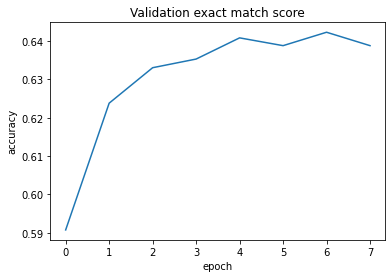

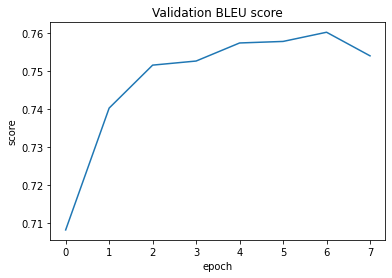

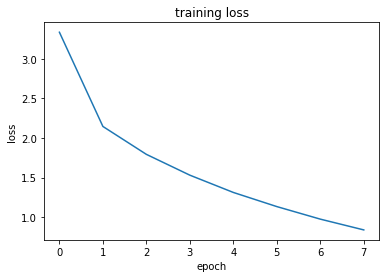

In [ ]:
from tqdm.keras import TqdmCallback

exact_match_callback = ExactMatch(x_validation, y_validation)
bleu_score_callback = BLEUScore(x_validation, y_validation)

history = model.fit(
    x_train,
    y_train,
    epochs=8,
    verbose=2,
    batch_size=16,
    callbacks=[
        TqdmCallback(verbose=2),
        exact_match_callback,
        bleu_score_callback
    ],
)

plt.plot(history.history['loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

## Error analysis

Let's analyse some of the best and worst results (in terms of validation metrics) to see where the trained model still fails.

In [ ]:
import random

positive_results = []
negative_results = []

for squad_eg, predicted_answer in get_predicted_answers(*model.predict(x_validation)):
    normalized_predicted_answer = normalize_text(predicted_answer)
    normalized_true_answers = [normalize_text(_) for _ in squad_eg.all_answers]

    display_result = {
        'Question': squad_eg.question,
        'True answers': squad_eg.all_answers,
        'Predicted answer': predicted_answer
    }
    if normalized_predicted_answer in normalized_true_answers:
        positive_results.append(display_result)
    else:
        negative_results.append(display_result)

print('Positive results:')
for res in random.sample(positive_results, 5):
    print(res)

print('\nNegative results:')
for res in random.sample(negative_results, 5):
    print(res)

277/277 [==============================] - 12s 42ms/step
Positive results:
{'Question': 'What name did Windows Explorer change to?', 'True answers': ['File Explorer'], 'Predicted answer': 'File Explorer'}
{'Question': 'How many people buy the Richmond Times-Dispatch on Sunday?', 'True answers': ['120,000'], 'Predicted answer': '120,000'}
{'Question': 'Pectoralis account for what percentage of total mass of a bird?', 'True answers': ['15%'], 'Predicted answer': '15%'}
{'Question': 'What was the October War?', 'True answers': ['surprise attack to regain part of the Sinai territory Israel had captured 6 years earlier'], 'Predicted answer': 'a surprise attack to regain part of the Sinai territory Israel had captured 6 years earlier'}
{'Question': 'What type of special lanes were added to Interstate 15?', 'True answers': ['high-occupancy-vehicle (HOV) "managed lanes"'], 'Predicted answer': 'high-occupancy-vehicle (HOV) "managed lanes'}

Negative results:
{'Question': 'What is the maximum le

## Save the model

Save the trained model for future use.

In [ ]:
model.save('trained_model.h5')

# In order to load it:
# model = tf.keras.models.load_model('trained_model.h5', custom_objects={'TFBertModel': TFBertModel})